In [39]:
"""
Для цієї роботи я використав датасет IMDB Movie Reviews, в якому близько 50 тис. записів.

Поля:
review: зберігає текст відгуку
sentiment: вказує позитивний/негативний відгук

Посилання: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

"""
# Імпортуємо бібліотеки
import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from transformers import pipeline
from flask import Flask, request, render_template
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [41]:
# Завантаження набору даних
df = pd.read_csv('IMDB Dataset.csv')

# Очистка та підготовка даних
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': -1})
X = df['review'].values
y = df['sentiment'].values

# Розділення даних на початковий тренувальний та тестовий набір
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Вибірка для активного навчання
X_pool, y_pool = shuffle(X_test, y_test, random_state=42)
initial_training_size = 100
active_iterations = 12
selection_size = 30

# Початковий тренувальний набір
X_initial, y_initial = X_pool[:initial_training_size], y_pool[:initial_training_size]
X_pool, y_pool = X_pool[initial_training_size:], y_pool[initial_training_size:]

In [43]:
# Створення базової моделі з використанням Logistic Regression
model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=200))

# Навчання початкової моделі
model.fit(X_initial, y_initial)

# Оцінка точності початкової моделі
y_initial_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_initial_pred)
print(f"Початкова точність моделі: {initial_accuracy:.4f}")

Початкова точність моделі: 0.4943


In [45]:
# Функція для активного вибору найбільш невизначених прикладів
def get_most_uncertain_samples(model, X_pool, n_samples=20):
    # Отримання передбачуваних ймовірностей
    probs = model.predict_proba(X_pool)
    # Визначення невпевненості як мінімум різниці між найвищими ймовірностями
    uncertainty = np.abs(probs[:, 0] - probs[:, 1])
    # Повертаємо індекси n_samples з найменшою впевненістю
    return np.argsort(uncertainty)[:n_samples]

# Активне навчання
accuracies = [initial_accuracy]
for i in range(active_iterations):
    # Вибір найбільш невпевнених прикладів для додавання до тренувального набору
    uncertain_indices = get_most_uncertain_samples(model, X_pool, selection_size)
    
    # Додавання вибраних прикладів до тренувального набору
    X_selected = [X_pool[i] for i in uncertain_indices]
    y_selected = y_pool[uncertain_indices]
    
    X_initial = np.concatenate((X_initial, X_selected))
    y_initial = np.concatenate((y_initial, y_selected))
    
    # Видалення вибраних прикладів із пулу
    X_pool = np.delete(X_pool, uncertain_indices, axis=0)
    y_pool = np.delete(y_pool, uncertain_indices, axis=0)
    
    # Перенавчання моделі
    model.fit(X_initial, y_initial)
    
    # Оцінка моделі на тестовому наборі
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Ітерація {i + 1}, Точність: {accuracy:.4f}")

# Фінальна оцінка моделі
print("\nФінальний звіт про класифікацію:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Ітерація 1, Точність: 0.5889
Ітерація 2, Точність: 0.6348
Ітерація 3, Точність: 0.6749
Ітерація 4, Точність: 0.7025
Ітерація 5, Точність: 0.7049
Ітерація 6, Точність: 0.7366
Ітерація 7, Точність: 0.7533
Ітерація 8, Точність: 0.7665
Ітерація 9, Точність: 0.7745
Ітерація 10, Точність: 0.7896
Ітерація 11, Точність: 0.8059
Ітерація 12, Точність: 0.8047

Фінальний звіт про класифікацію:
              precision    recall  f1-score   support

          -1       0.84      0.74      0.79      7411
           1       0.77      0.87      0.82      7589

    accuracy                           0.80     15000
   macro avg       0.81      0.80      0.80     15000
weighted avg       0.81      0.80      0.80     15000



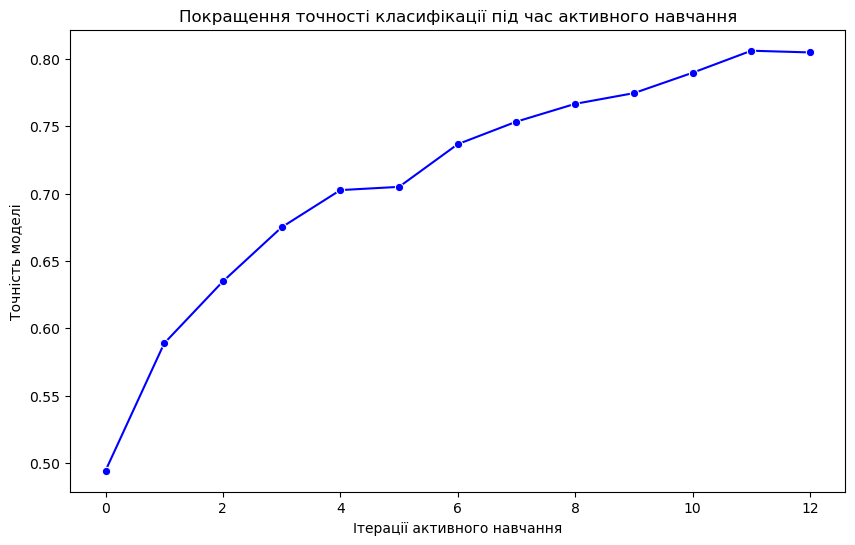

In [47]:
# Візуалізація результатів точності
iterations = list(range(0, active_iterations + 1))

plt.figure(figsize=(10, 6))
sns.lineplot(x=iterations, y=accuracies, marker='o', color='b')
plt.xlabel('Ітерації активного навчання')
plt.ylabel('Точність моделі')
plt.title('Покращення точності класифікації під час активного навчання')
plt.show()

In [59]:
# Створення веб-інтерфейсу для анотації за допомогою Flask
app = Flask(__name__)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/annotate', methods=['POST'])
def annotate():
    # Отримання випадкового тексту з пулу для анотації
    if len(X_pool) > 0:
        index = random.choice(range(len(X_pool)))
        text = X_pool[index]
        return render_template('annotate.html', text=text, index=index)
    else:
        return "Пул текстів для анотації порожній."

@app.route('/submit_annotation', methods=['POST'])
def submit_annotation():
    index = int(request.form['index'])
    sentiment = int(request.form['sentiment'])
    global X_initial, y_initial, X_pool, y_pool

    # Додавання анотації до тренувального набору
    X_initial = np.concatenate((X_initial, [X_pool[index]]))
    y_initial = np.concatenate((y_initial, [sentiment]))

    # Видалення тексту з пулу
    X_pool = np.delete(X_pool, index, axis=0)
    y_pool = np.delete(y_pool, index, axis=0)

    # Перенавчання моделі
    model.fit(X_initial, y_initial)

    return "Анотація збережена, модель оновлена."

if __name__ == '__main__':
    app.run(debug=True, port=5001, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit


In [ ]:
"""
Сценарій використання веб-додатку:
1. Користувач відкриває веб-сторінку: Відображається головна сторінка з кнопкою "Анотувати текст".
2. Користувач починає анотацію: Натискає кнопку і отримує текст для анотації.
3. Вибір тональності: Користувач читає текст та обирає відповідну тональність з випадаючого списку.
4. Надсилання результату: Після вибору тональності натискає кнопку для збереження анотації, модель перенавчається.
5. Повторення процесу: Користувач може продовжувати анотувати тексти доти, доки в пулі не залишиться текстів для анотації.

Висновки:
Початкова точність моделі складала 49.43%, що говорить про випадкове передбачення чи слабку початкову навчальну вибірку.
Після 12 ітерацій активного навчання точність моделі значно покращилася і досягла 80.47%. 
Це показує, що активне навчання ефективно допомогло моделі вибрати найбільш інформативні зразки для подальшого навчання.

Precision та Recall показують, що модель працює трохи краще для класу 1 (позитивний настрій), ніж для класу -1 (негативний настрій).

Активне навчання значно підвищило точність моделі, особливо у перших кількох ітераціях, що свідчить про успішний вибір 
найбільш невпевнених зразків для навчання.

Для швидкої розробки веб-додатку використав веб-фреймворк Flask
"""